In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

from datetime import datetime, timedelta
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import os
import json
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import shap

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings("ignore")

random_state = 42
np.random.seed(random_state)
random.seed(random_state)
os.environ['PYTHONHASHSEED']=str(random_state)

In [2]:
#!pip install mne-features
#!pip install shap
#!pip install imbalanced-learn

# Load data

In [2]:
from data_utils import *

In [3]:
eeg_dataset = EEGdataset('data')
prepared_data,labels,subject_labels = eeg_dataset.get_splitted_data(window_size=2,overlap=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [02:04<00:00,  7.35s/it]


In [4]:
print(f'Class distridution: {Counter(labels)}')
print(f'Ratio of majority to minority class',round(Counter(labels)[0]/Counter(labels)[1],3))

Class distridution: Counter({0: 10457, 1: 3863})
Ratio of majority to minority class 2.707


It can be seen that the dataset is quite unbalanced.
In this case, it is important that both precision and recall would be high, especially for the minor class (professionals), since we want to capture all possible distinctive patterns of pro players brain activity, but at the same time not falsely identify a beginner as a pro player.\
Therefore, weighted F1_score will be used as a metric for evaluating model performances. And the usage of upsampling technique will be tested.

In [5]:
#get train,val,test indices
train_val_ids,test_ids = train_test_split(np.arange(len(labels)), test_size=0.2, random_state=random_state,stratify = labels)
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.2, random_state=random_state,stratify = np.array(labels)[train_val_ids])

**Project pipeline**

In this work, 2 subgroups of features are extracted - basic time-domain features and autonomic EEG indices (taken from studies on the rhythm analysis in relation to human behavior and preferences)

*Time-domain features* (per channel):
* Minimum,Maximum,Mean,Std
* 1st Quartile, 2nd Quartile (Median), 3rd Quartile
* Hjorth parameters (complexity, mobility)
* Skewness
* Kurtosis
* Root mean square
* Decorrelation time
* Peak-to-peak (PTP) amplitude
* Katz Fractal Dimension
* Area under the curve
* Variance
* Entropy
  
*Autonomic EEG indices*:
* Approach-Withdrawal (AW) Index -  measures the frontal alpha asymmetry and serves for the evaluation of engagement/disengagement towards the stimuli (in this case - game)
* Effort Index - reflectes the activity level of the frontal theta in the prefrontal cortex and serves as the indication of cognitive processing. Higher theta activity associates with higher levels of task difficulty and complexity in the frontal area.
* Valence Index - measures the asymmetrical activation of the frontal hemisphere that correlates to player preferences.
* Choice Index - measures the frontal irregular fluctuations in beta and gamma, associated with the actual stage of decision-making.\
(all of the above are based on frontal area channels. similar indices were measured for the temporal cortex)

*Project steps*
1. training on basic time features, best model selection
2. adding autonomic features and evaluating the best model from the previous step
3. testing dimensionality reduction and feature selection methods, as well as the upsampling for balancing the class distribution
4. analyzing the model results

# 1. Hyperparameters search and best model selection

In [6]:
scaler = StandardScaler()

channel_mapping = eeg_dataset.get_channel_mapping()

X_train_raw = prepared_data[train_ids]
X_train,feature_names = get_features(X_train_raw,channel_mapping,eeg_dataset.sampling_period,extract_rch_features=False)
X_train_scl = scaler.fit_transform(X_train)
y_train = np.array(labels)[train_ids]
print('Train features constructed...')

X_val_raw = prepared_data[val_ids]
X_val,_ = get_features(X_val_raw,channel_mapping,eeg_dataset.sampling_period,extract_rch_features=False)
X_val_scl = scaler.transform(X_val)
print('Val features constructed...')
y_val = np.array(labels)[val_ids]

X_test_raw = prepared_data[test_ids]
X_test,_ = get_features(X_test_raw,channel_mapping,eeg_dataset.sampling_period,extract_rch_features=False)
X_test_scl = scaler.transform(X_test)
print('Test features constructed...')
y_test = np.array(labels)[test_ids]
#test set will be used only for best model evaluation 

Train features constructed...
Val features constructed...
Test features constructed...


In [7]:
X_train.shape
#now for train set we have 1260 features per each of 7755 samples (18 feature per each of 70 channels [14 electrodes x 5 rhythm bands])

(9164, 1260)

# Hyperparameters search and best model selection

In [13]:
#Define model search and hyperparameter optimization settings
search_dict = {     'Logistic':     {'model': LogisticRegression(random_state=random_state),
                                     'param_grid':
                                              {'solver':        ['liblinear'],
                                               'penalty':       ['l1', 'l2'],  #for LR  try both L1 and L2 regularizations
                                               'C':             [0.001, 0.01, 1, 10],
                                               'max_iter':        [80],
                                               'tol': [1e-6]}
                    },
                    'Random Forest':{'model': RandomForestClassifier(random_state=random_state,n_jobs=-1),
                                     'param_grid':
                                              { 'max_features': ['sqrt', 'log2'],
                                                'ccp_alpha':    [0.01, 0.001],
                                                'max_depth' :   [3, 4, 5],
                                                'criterion' :   ['gini', 'entropy'],
                                              }
                                    },
                   'SVC':           {'model': SVC(random_state=random_state),
                                     'param_grid':
                                            {'C': np.logspace(-3, -1, 10),
                                             'kernel': ['linear', 'rbf']
                                            }
                                    },
                   'K-Neighbors':   {'model': KNeighborsClassifier(n_jobs=-1),
                                     'param_grid':
                                            {'n_neighbors': [3, 5, 7, 10, 15, 20, 30, 35]
                                            }
                                    },
                   'MLP':           {'model': MLPClassifier(random_state=random_state),
                                     'param_grid':
                                            {'max_iter': [150, 250],
                                             'solver':['adam','lbfgs'],
                                             'alpha': [1e-3,1e-4],
                                             'hidden_layer_sizes': [(200,),(300,)]
                                            }
                                    }
                  }

def do_search(X, y,search_dict,random_state=42):
  for exp_name, test_option in search_dict.items():
      model = test_option['model']
      param_grid = test_option['param_grid']
      cv = RandomizedSearchCV(model, param_grid, cv=5, scoring='f1_weighted',
                           random_state=random_state,
                           n_jobs=-1)
      cv.fit(X, y)
      print(exp_name,'\t', cv.best_params_)

In [14]:
do_search(X_train_scl, y_train,search_dict,random_state=42)

Logistic 	 {'tol': 1e-06, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 80, 'C': 10}
Random Forest 	 {'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'gini', 'ccp_alpha': 0.001}
SVC 	 {'kernel': 'linear', 'C': 0.1}
K-Neighbors 	 {'n_neighbors': 15}
MLP 	 {'solver': 'adam', 'max_iter': 150, 'hidden_layer_sizes': (200,), 'alpha': 0.001}


In [15]:
#compare model performances (on val set) using cross validation
models_with_best_params=[LogisticRegression(random_state = random_state,
                                            solver = 'liblinear',
                                            penalty = 'l1',
                                            C = 10,
                                            tol = 1e-06),
                         RandomForestClassifier(random_state = random_state,
                                                n_jobs = -1,
                                                max_features = 'sqrt',
                                                max_depth = 5,
                                                criterion = 'gini',
                                                ccp_alpha = 0.001),
                         SVC(random_state=random_state,
                             C =0.1,
                             kernel = 'linear'),
                         KNeighborsClassifier(n_jobs = -1,
                                              n_neighbors = 15),
                         MLPClassifier(random_state = random_state,
                                       solver = 'adam',
                                       max_iter = 150,
                                       hidden_layer_sizes = (200,),
                                       alpha = 1e-4
                                      )
]
Classifiers = list(search_dict.keys())
rows = ['mean cross val', 'st dev', 'score on train', 'score on test']

score = pd.DataFrame(np.ones([4,len(search_dict.keys())]), index = rows, columns=Classifiers)

for j, clf in enumerate(models_with_best_params):
  approach = clf
  cros = cross_val_score(approach, np.vstack([X_train_scl,X_val_scl]), np.hstack([y_train,y_val]), scoring='f1_weighted', cv=5,n_jobs=-1)
  cross_validat_score = np.mean(cros)
  st_dev = np.std(cros)
  score.iloc[0,j] = cross_validat_score
  score.iloc[1,j] = st_dev

for i, clf in enumerate(models_with_best_params):
  tt = clf.fit(X_train_scl, y_train)
  train = (abs(clf.score(X_train_scl, y_train)))
  test = (abs(clf.score(X_val_scl, y_val)))
  score.iloc[2,i] = train
  score.iloc[3,i] = test

print('Cross-validation scores')
print("f1_weighted")
display(score)

Cross-validation scores
f1_weighted


Logistic  Random Forest       SVC  K-Neighbors       MLP
mean cross val  0.971214       0.972196  0.907345     0.725802  0.881629
st dev          0.003830       0.003266  0.008458     0.003570  0.008786
score on train  0.997490       0.976866  0.931907     0.790703  1.000000
score on test   0.972949       0.966841  0.905759     0.739965  0.879145

It can be seen that Random Forest and Logistic Regression classifiers perform better than the others on the validation set. We select Random Forest for the further analysis as it shows a bit higher weighted F1-score compared Logistic Regression, has a bit lower std and provides built-in feature importances.

Let's evaluate the best model result on the test set and analyze its feature importance.

In [93]:
from sklearn.metrics import roc_auc_score, roc_curve,f1_score,balanced_accuracy_score
def evaluate_model(y_test, y_pred,model_name):
    print('Roc auc score:\t ',round(roc_auc_score(y_test, y_pred),3))
    print('F1:\t ',round(f1_score(y_test, (y_pred>=0.5).astype(int),average='weighted'),3))
    
    fig,ax = plt.subplots(figsize=(6,4))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    ax.plot(fpr, tpr, label=model_name)
    ax.plot([0,1], [0,1])
    ax.set(xlabel='False Positive Rate (Treating casuals as pro)',ylabel='True Positive Rate',title='Roc curve')
    ax.legend(loc='lower right');  

def get_feature_importance(model,X_train,X_test,feature_names,top_n=20):
    fig,axes = plt.subplots(1,2,figsize=(14,2),dpi=600)
    
    # built-in model importances
    importances = model.feature_importances_
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
    
    axes[0].barh(feature_imp_df.head(top_n).Feature.values,feature_imp_df.head(top_n)['Gini Importance'].values, color='skyblue')
    axes[0].set(xlabel='Gini Importance',title='Feature Importance - Gini Importance')
    axes[0].invert_yaxis() # Invert y-axis for better visualization
    # SHAP importances
    explainer = shap.Explainer(best_model, X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values[:,:,1], X_test,feature_names=feature_names, show=False,plot_size=(10,5),max_display=top_n)
    axes[1] = plt.gca()
    axes[1].tick_params(axis='x', labelsize=12)
    axes[1].tick_params(axis='y', labelsize=10)
    axes[1].set_title("SHAP Importance")

Roc auc score:	  0.999
F1:	  0.965


 98%|===================| 5587/5728 [00:15<00:00]        

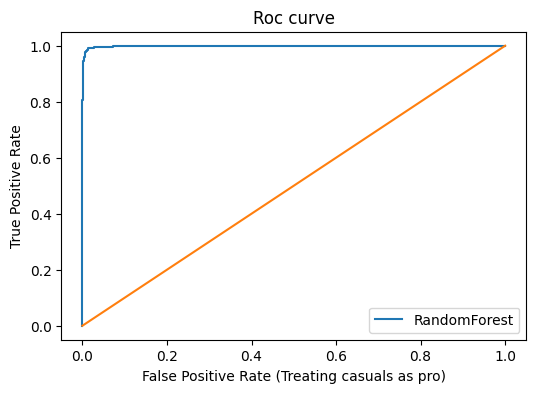

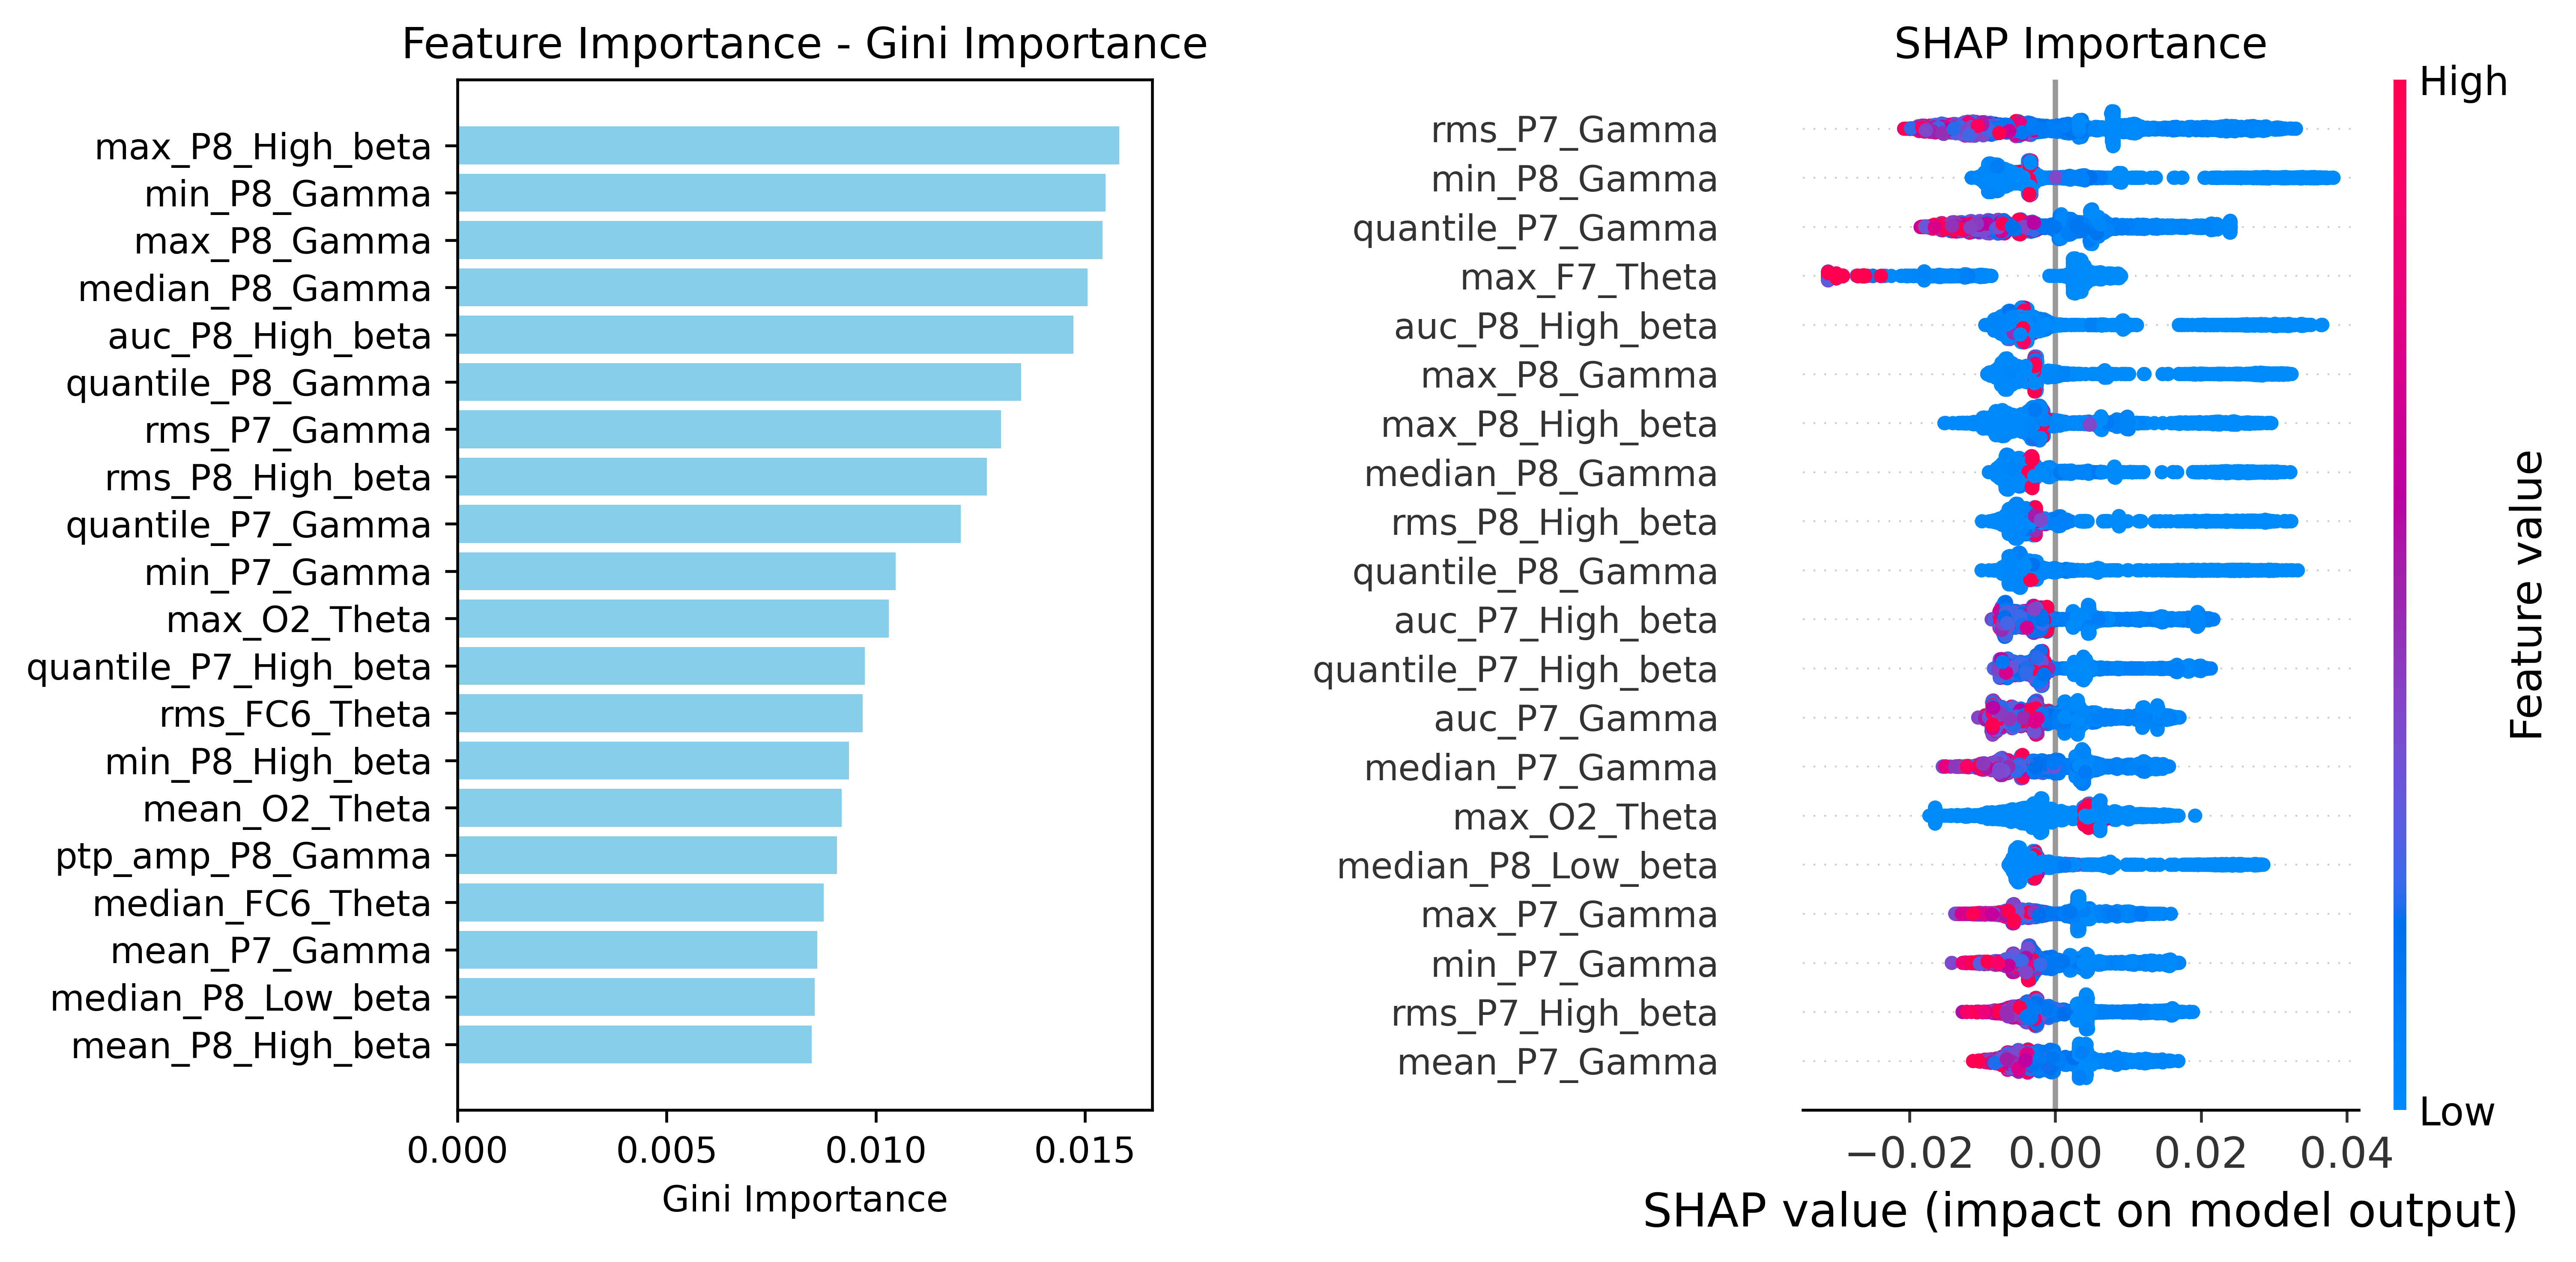

In [94]:
best_model = RandomForestClassifier(random_state = random_state,
                                                n_jobs = -1,
                                                max_features = 'sqrt',
                                                max_depth = 5,
                                                criterion = 'gini',
                                                ccp_alpha = 0.001)
best_model.fit(X_train_scl,y_train)
y_pred = best_model.predict_proba(X_test_scl)[:, 1]
evaluate_model(y_test, y_pred,'RandomForest')
get_feature_importance(best_model,X_train_scl,X_test_scl,feature_names,top_n=20)

It is clear that the most important features are almost the same both with the built-in impurity-based feature importance analysis and with the calculation of the Shapley values. They also largely coincide with the findings at the exploratory data analysis stage. Specifically, the most distinctive are the brain activities in the gamma and beta frequency bands of the temporal cortex (P7, P8), as well as the theta rithm of the occipital lobe (O2 channel), which is responsible for processing visual information. According to the SHAP analysis (built for pro class), it can be concluded that all the previously listed features (except max_Theta_O2) have an inverse relationship with professionalism (the lower their values, the more likely the considered time interval belongs to a pro player).\
Also, gamma waves are thought to be a sign of the active exchange of information between the cerebral cortex and other areas, and usually generated in the brain when people are conscious and when the eyes move rapidly. Gamma and beta waves often overlap within the range of natural frequencies, and the exact boundary between these two frequency bands is not clear. Therefore, these 2 frequency bands are the most distinctive and are presented together.

# 2. Add more features (autonomic EEG indices)

In [67]:
scaler = StandardScaler()

#now set option extract_rch_features = True
X_train_ext,feature_names_ext = get_features(X_train_raw,channel_mapping,eeg_dataset.sampling_period,extract_rch_features=True)
X_train_ext_scl = scaler.fit_transform(X_train_ext)
print('Extended train features constructed...')

X_val_ext,_ = get_features(X_val_raw,channel_mapping,eeg_dataset.sampling_period,extract_rch_features=True)
X_val_ext_scl = scaler.transform(X_val_ext)
print('Extended Val features constructed...')

X_test_ext,_ = get_features(X_test_raw,channel_mapping,eeg_dataset.sampling_period,extract_rch_features=True)
X_test_ext_scl = scaler.transform(X_test_ext)
print('Extended test features constructed...')

Extended train features constructed...
Extended Val features constructed...
Extended test features constructed...


In [68]:
X_train_ext.shape
#now for train set we have 1278 features (18 time-domain features per each of 70 channels + 18 autonomic features)

(9164, 1278)

In [69]:
model = RandomForestClassifier(random_state = random_state,n_jobs = -1)

param_grid = search_dict['Random Forest']['param_grid']

cv = RandomizedSearchCV(model, param_grid, cv=5, scoring='f1_weighted',n_jobs=-1)
cv.fit(X_train_ext_scl, y_train)
print(cv.best_params_)

{'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': 0.001}


In [70]:
model_with_best_params = RandomForestClassifier(random_state = random_state,
                                                n_jobs = -1,
                                                max_features = 'sqrt',
                                                max_depth = 5,
                                                criterion = 'entropy',
                                                ccp_alpha = 0.001)
#compute cs score for train+val data and then evaluate model on test set
cv_score = cross_val_score(model_with_best_params, np.vstack([X_train_ext_scl,X_val_ext_scl]), np.hstack([y_train,y_val]), scoring='f1_weighted', cv=5,n_jobs=-1)
print(f"The mean score using cross-validation is: "
        f"{cv_score.mean():.3f} ± {cv_score.std():.3f}")

The mean score using cross-validation is: 0.969 ± 0.005


Roc auc score:	  0.999
F1:	  0.965


 96%|=================== | 5480/5728 [00:15<00:00]       

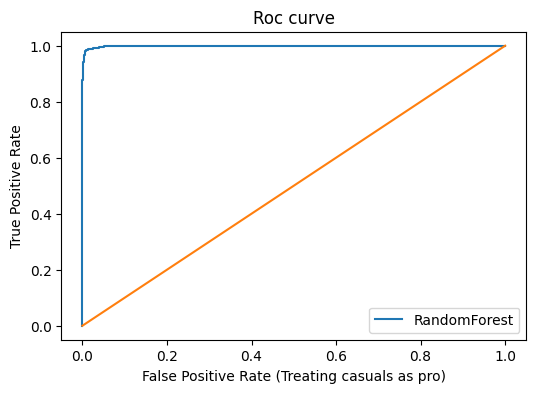

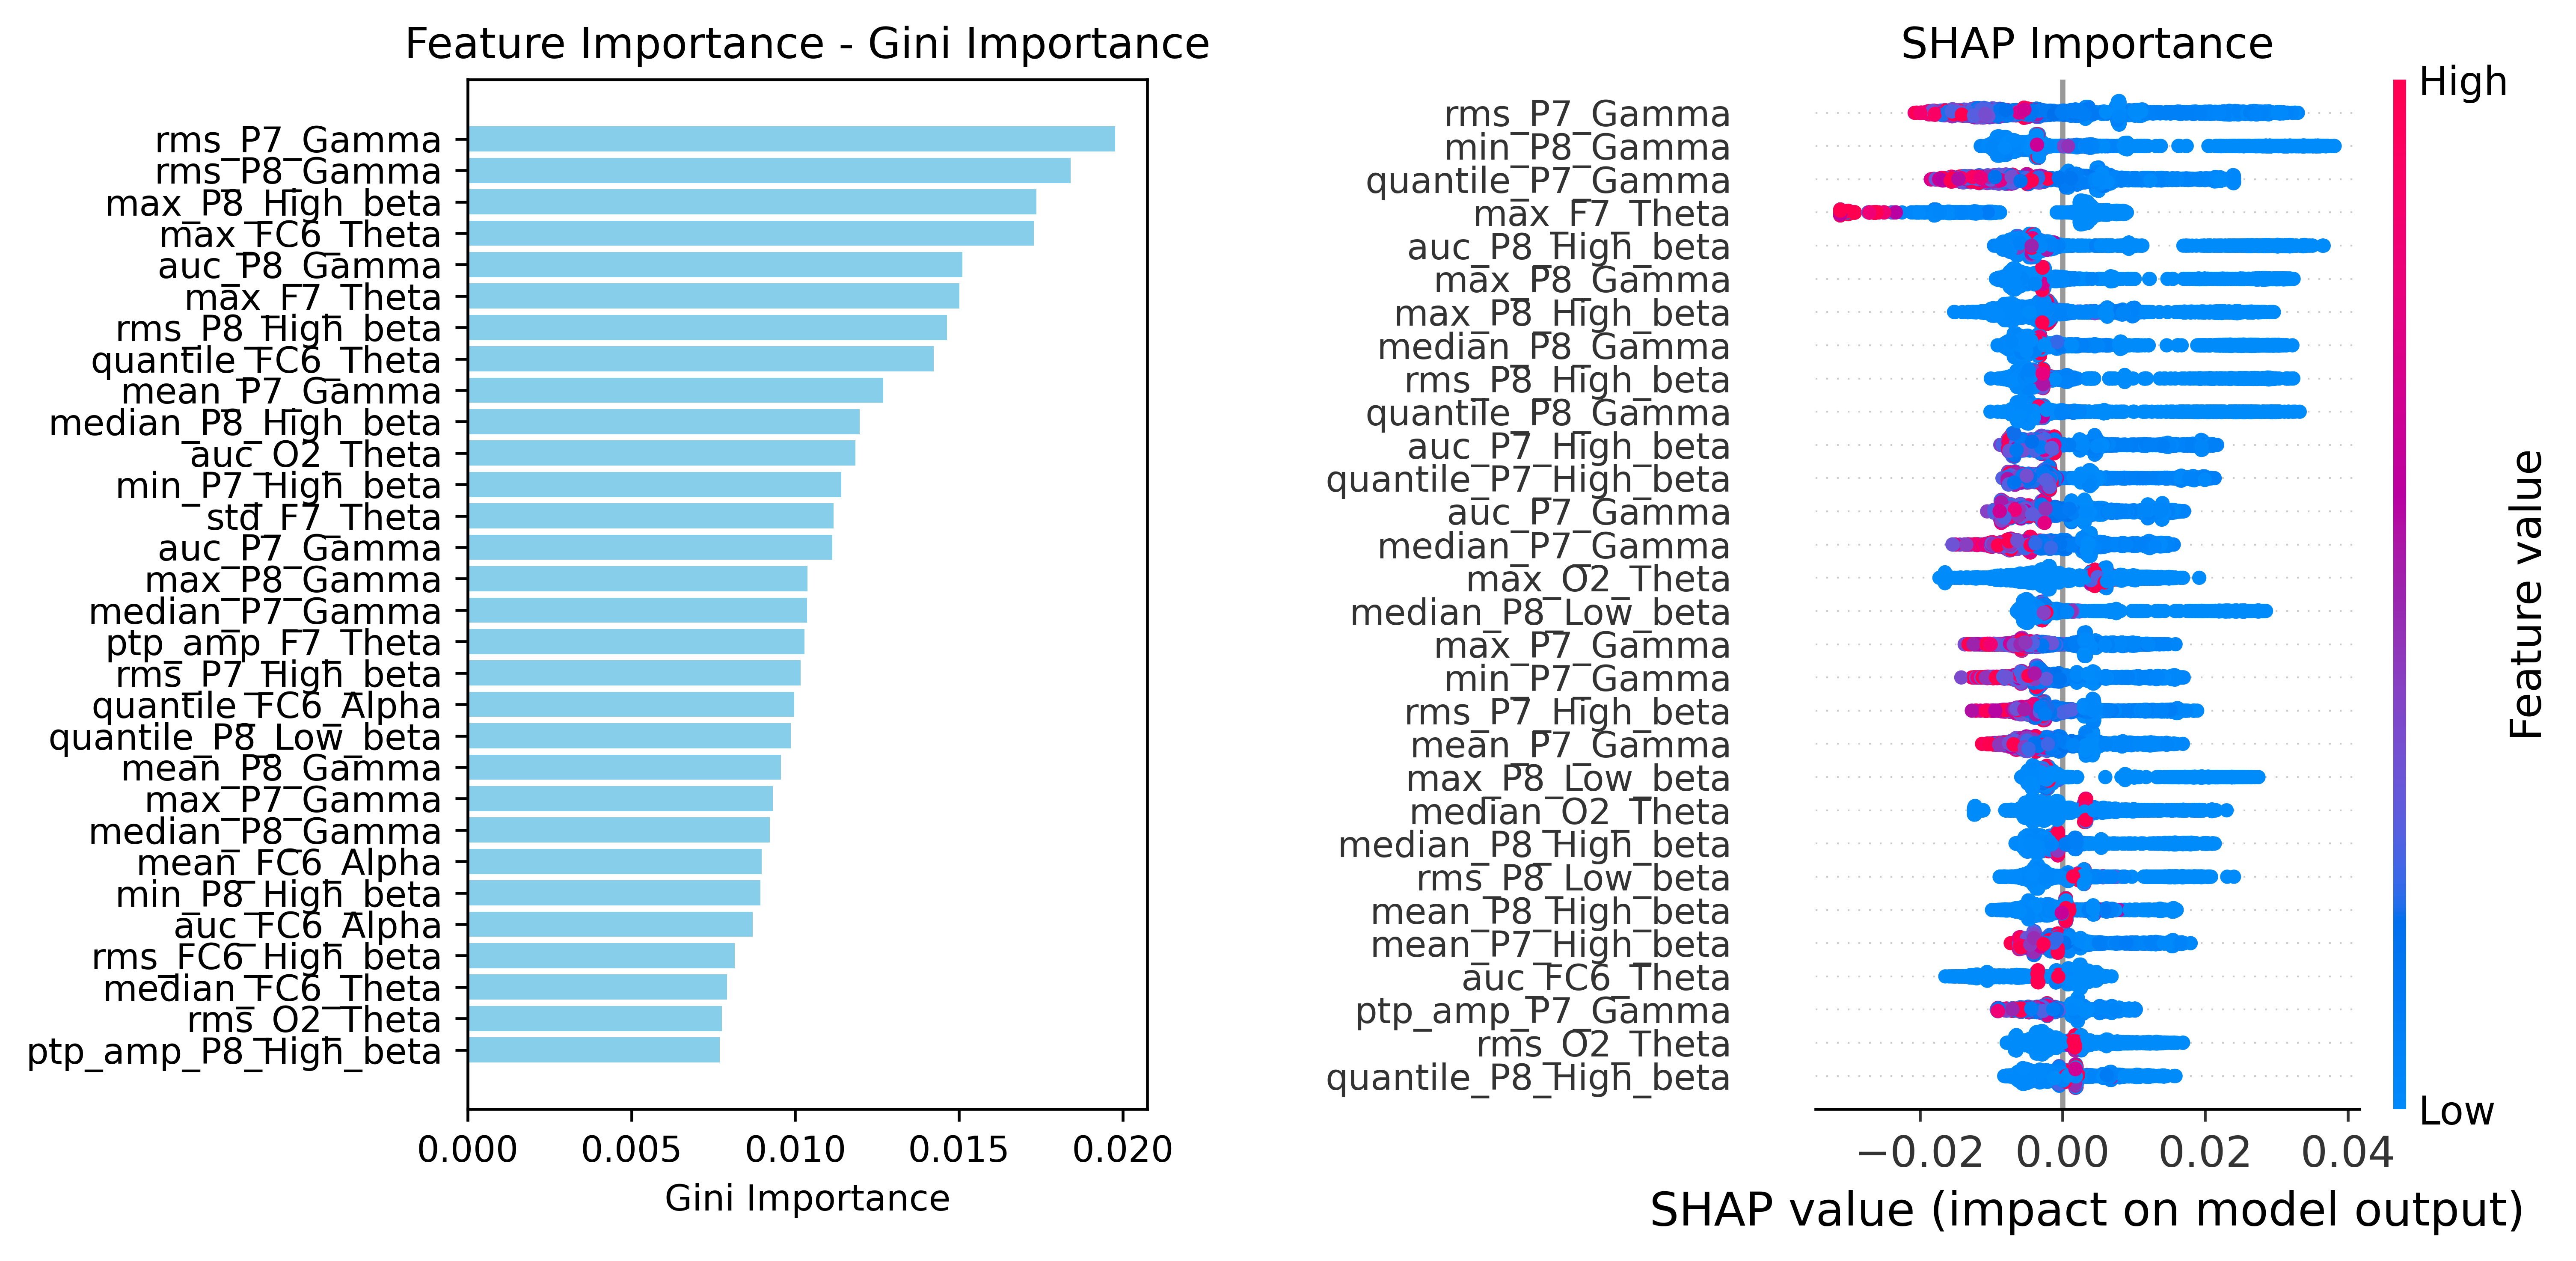

In [95]:
model_with_best_params.fit(X_train_ext_scl, y_train)
y_pred = model_with_best_params.predict_proba(X_test_ext_scl)[:, 1]
evaluate_model(y_test, y_pred,'RandomForest')
get_feature_importance(model_with_best_params,X_train_ext_scl,X_test_ext_scl,feature_names_ext,top_n=30)

The features importance analysis shows that autonomic EEG indices do not get in the top important features, while the mostsignificant ones are practically the same as in the previous case for both methods. Overall, the model performs well.

# 3. Test Performance Improvement Methods (dimensionality reduction & feature selection, upsampling)

## 3.1 Dimensionality reduction & feature selection methods

First, apply dimensionality reduction and feature selection methods and evaluate the results, and then test the upsampling method on the best option.

In [84]:
from sklearn.feature_selection import SelectKBest
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

#create table for results
indexes_ = [('Feature Selection','SelectKBest','time-domain'),
            ('Feature Selection','SelectKBest','mixed'),
            ('Dimension Reduction','PCA','time-domain'),
            ('Dimension Reduction','PCA','mixed')]
columns = [('Random Forest','weighted_f1_score'),
            ('Random Forest','±std')]
row_list = pd.MultiIndex.from_tuples(indexes_)
col_list = pd.MultiIndex.from_tuples(columns)
new_scores = pd.DataFrame(np.ones([len(row_list),len(col_list)]), row_list,col_list)

# use nested cross-validation
#set the inner and outer cross-validation strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

def compute_nested_cross_validation(model_to_tune, param_grid,features,labels,inner_cv=inner_cv,outer_cv=outer_cv,verbose=0):
    
    model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=-1)
    test_score = cross_val_score(model, features, labels, cv=outer_cv, n_jobs=-1, scoring='f1_weighted',verbose=verbose)
    # print(f"The mean score using nested cross-validation is: "
    #       f"{test_score.mean():.3f} ± {test_score.std():.3f}")
    return test_score.mean(),test_score.std()

time_domain_features = np.vstack([X_train_scl,X_val_scl])
mixed_features = np.vstack([X_train_ext_scl,X_val_ext_scl])
labels = np.hstack([y_train,y_val])

### SelectKBest 

Filter method: Univariate feature selection based on statistical tests.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import FeatureUnion

#add the SelectKBest modification to select not a specific number k of the most important features, but the feature importance threshold p_thresh
class ModifiedSelectKBest(BaseEstimator,TransformerMixin):  
    def __init__(self,p_thresh=0.05):
        self.selector = SelectKBest(k='all')
        self.p_thresh = p_thresh

    def fit(self,X,y=None):
        self.selector.fit(X, y)
        return self
    
    def transform(self,X,y=None):
        return X[:,self.selector.pvalues_<=self.p_thresh]
        
class ColumnExtractor(object):
    def __init__(self, col_indexes):
        self.col_indexes = col_indexes
    def transform(self, X):
        return X[:,self.col_indexes]
    def fit(self, X, y=None):
        return self
        
fs_params = {'feature_selector': [ModifiedSelectKBest(),ModifiedSelectKBest(0.01),SelectKBest(k=500),SelectKBest(k=100)]}

param_grid = search_dict['Random Forest']['param_grid']

new_scores.loc[('Feature Selection','SelectKBest', "time-domain"), ('Random Forest')] = compute_nested_cross_validation(model_to_tune = Pipeline(steps=[
                                                            ("feature_selector", None),
                                                            ("classifier", RandomForestClassifier(random_state = random_state,n_jobs = -1))]),
                                                            param_grid = {**{'classifier__'+k:v for k,v in param_grid.items()},**fs_params},
                                                            features=time_domain_features,
                                                            labels = labels)
new_scores.loc[('Feature Selection','SelectKBest', "mixed"), ('Random Forest')] = compute_nested_cross_validation(model_to_tune = Pipeline(steps=[
                                                            ("feature_selector", None),
                                                            ("classifier", RandomForestClassifier(random_state = random_state,n_jobs = -1))]),
                                                            param_grid = {**{'classifier__'+k:v for k,v in param_grid.items()},**fs_params},
                                                            features=mixed_features,
                                                            labels = labels)

### PCA

In [91]:
new_scores.loc[('Dimension Reduction','PCA', "time-domain"), ('Random Forest')] = compute_nested_cross_validation(model_to_tune = Pipeline(steps=[
                                                            ("dim_reduction", PCA(.95)),
                                                            ("classifier", RandomForestClassifier(random_state = random_state,n_jobs = -1))]),
                                                            param_grid = {**{'classifier__'+k:v for k,v in param_grid.items()}},
                                                            features=time_domain_features,
                                                            labels = labels)

new_scores.loc[('Dimension Reduction','PCA', "mixed"), ('Random Forest')]= compute_nested_cross_validation(model_to_tune = Pipeline(steps=[
                                                            ("dim_reduction", PCA(.95)),
                                                            ("classifier", RandomForestClassifier(random_state = random_state,n_jobs = -1))]),
                                                            param_grid = {**{'classifier__'+k:v for k,v in param_grid.items()}},
                                                            features=mixed_features,
                                                            labels = labels)

### Results

In [92]:
display(new_scores)

Random Forest          
                                            weighted_f1_score      ±std
Feature Selection   SelectKBest time-domain          0.982368  0.002984
                                mixed                0.986452  0.003069
Dimension Reduction PCA         time-domain          0.616648  0.006896
                                mixed                0.616442  0.007039

The table shows that the SelectKBest feature selection method generally performs better than PCA. That is, direct removal of uninformative features for a given dataset is better than converting all features into principal components.\
Let's determine the best hyperparameters of the model and a specific SelectKBest setup for mixed features using cross-validation. Next, evaluate and analyze features on the test set.

In [99]:
best_model_to_tune =  Pipeline(steps=[("feature_selector", None),
                                      ("classifier", RandomForestClassifier(random_state = random_state,n_jobs = -1))])
cv = GridSearchCV(estimator=best_model_to_tune, param_grid={**{'classifier__'+k:v for k,v in param_grid.items()},**fs_params}, cv=5, n_jobs=-1)
cv.fit(mixed_features, labels)
print(cv.best_params_)

{'classifier__ccp_alpha': 0.001, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'feature_selector': SelectKBest(k=500)}


Roc auc score:	  0.999
F1:	  0.987


 94%|=================== | 5394/5728 [00:14<00:00]       

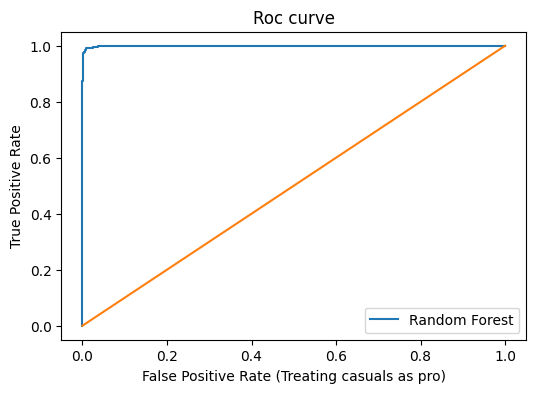

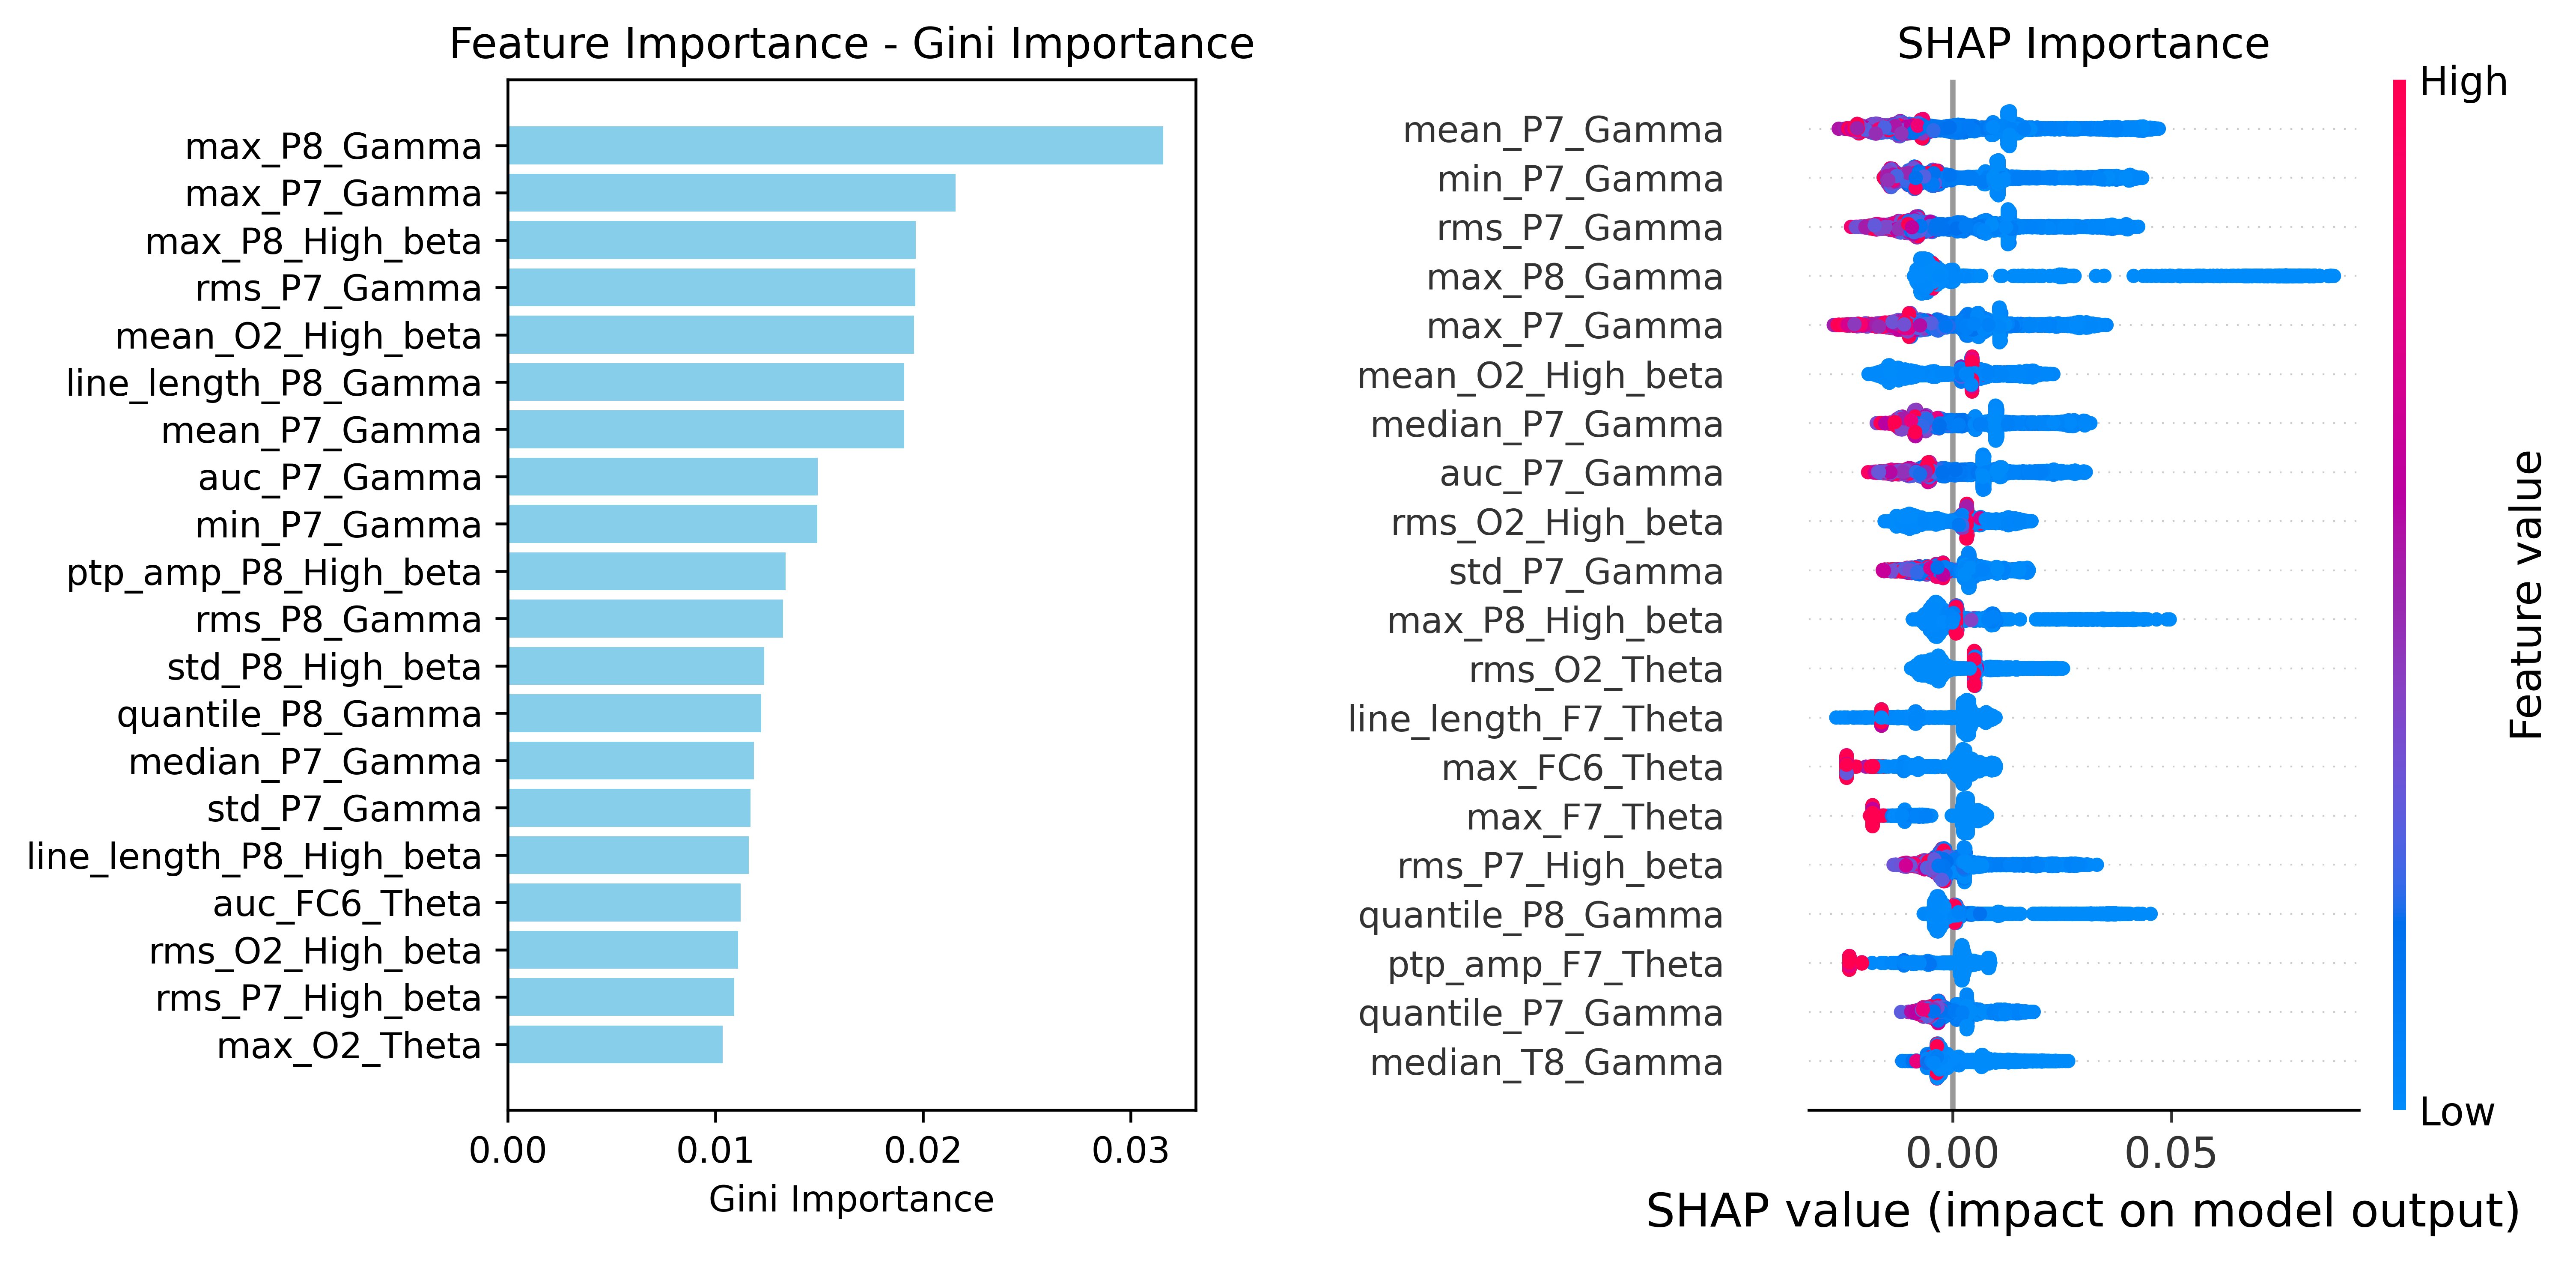

In [107]:
select_k_best = SelectKBest(k=500)
best_model =  RandomForestClassifier(random_state = random_state,
                                                n_jobs = -1,
                                                max_features = 'sqrt',
                                                max_depth = 5,
                                                criterion = 'gini',
                                                ccp_alpha = 0.001)
select_k_best.fit(mixed_features,labels)
X_train_val_sel = select_k_best.transform(mixed_features)
X_test_sel = select_k_best.transform(X_test_ext_scl)


best_model.fit(X_train_val_sel, labels)
y_pred = best_model.predict_proba(X_test_sel)[:, 1]
evaluate_model(y_test, y_pred,'Random Forest')

get_feature_importance(best_model,X_train_val_sel,X_test_sel,np.array(feature_names_ext)[select_k_best.get_support(indices=True)],top_n=20)

In [110]:
print(f'Initial feature space size {mixed_features.shape[1]}, features space size after feature selection - 500')

Initial feature space size 1278, features space size after feature selection - 500


It can be seen that the model began to perform a little better regarding f1 score. The most important features remained almost the same as in the previous cases. At the same time, the dimension of the feature space decreased by 60%.

## 3.2 Upsampling 

In [132]:
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.pipeline import Pipeline as Pipeline_imb

#create table for results
rows = ['mean cross val', 'st dev']
columns = [ ('SMOTE','0.65'),
            ('SMOTE','0.85'),
            ('ADASYN','0.65'),
            ('ADASYN','0.85'),
          ]
col_list = pd.MultiIndex.from_tuples(columns)
up_scores = pd.DataFrame(np.ones([len(rows),len(col_list)]), rows,col_list)

up_methods = [SMOTE(sampling_strategy=0.65,random_state=random_state),SMOTE(sampling_strategy=0.85,random_state=random_state),
              ADASYN(sampling_strategy=0.65,random_state=random_state),ADASYN(sampling_strategy=0.85,random_state=random_state)]


for j, up_method in enumerate(up_methods):
    sc, std = compute_nested_cross_validation(model_to_tune = Pipeline_imb(steps=[
                                                            ("upsampling", up_method),
                                                            ("classifier", RandomForestClassifier(random_state = random_state,n_jobs = -1))]),
                                                            param_grid = {**{'classifier__'+k:v for k,v in param_grid.items()}},
                                                            features=X_train_val_sel,
                                                            labels = labels)
    up_scores.loc['mean cross val',columns[j]] = sc
    up_scores.loc['st dev',columns[j]] = std

In [133]:
display(up_scores)

SMOTE              ADASYN          
                    0.65      0.85      0.65      0.85
mean cross val  0.990558  0.984794  0.991518  0.990055
st dev          0.000756  0.002598  0.002488  0.001412

In [125]:
print(f'The initial ratio for the train+val set {round(Counter(labels)[1]/Counter(labels)[0],2)}')

The initial ratio for the train+val set 0.37


In [126]:
best_model_to_tune =  Pipeline_imb(steps=[("upsampling", ADASYN(sampling_strategy=0.65,random_state=random_state)),
                                           ("classifier", RandomForestClassifier(random_state = random_state,n_jobs = -1))])
cv = GridSearchCV(estimator=best_model_to_tune, param_grid={**{'classifier__'+k:v for k,v in param_grid.items()}}, cv=5, n_jobs=-1)
cv.fit(X_train_val_sel, labels)
print(cv.best_params_)

{'classifier__ccp_alpha': 0.001, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt'}


Roc auc score:	  0.999
F1:	  0.988


100%|===================| 5714/5728 [00:14<00:00]        

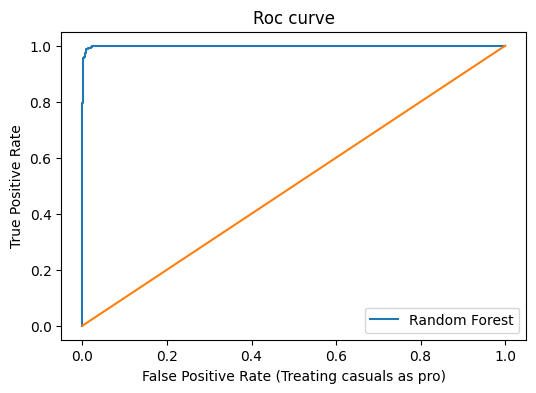

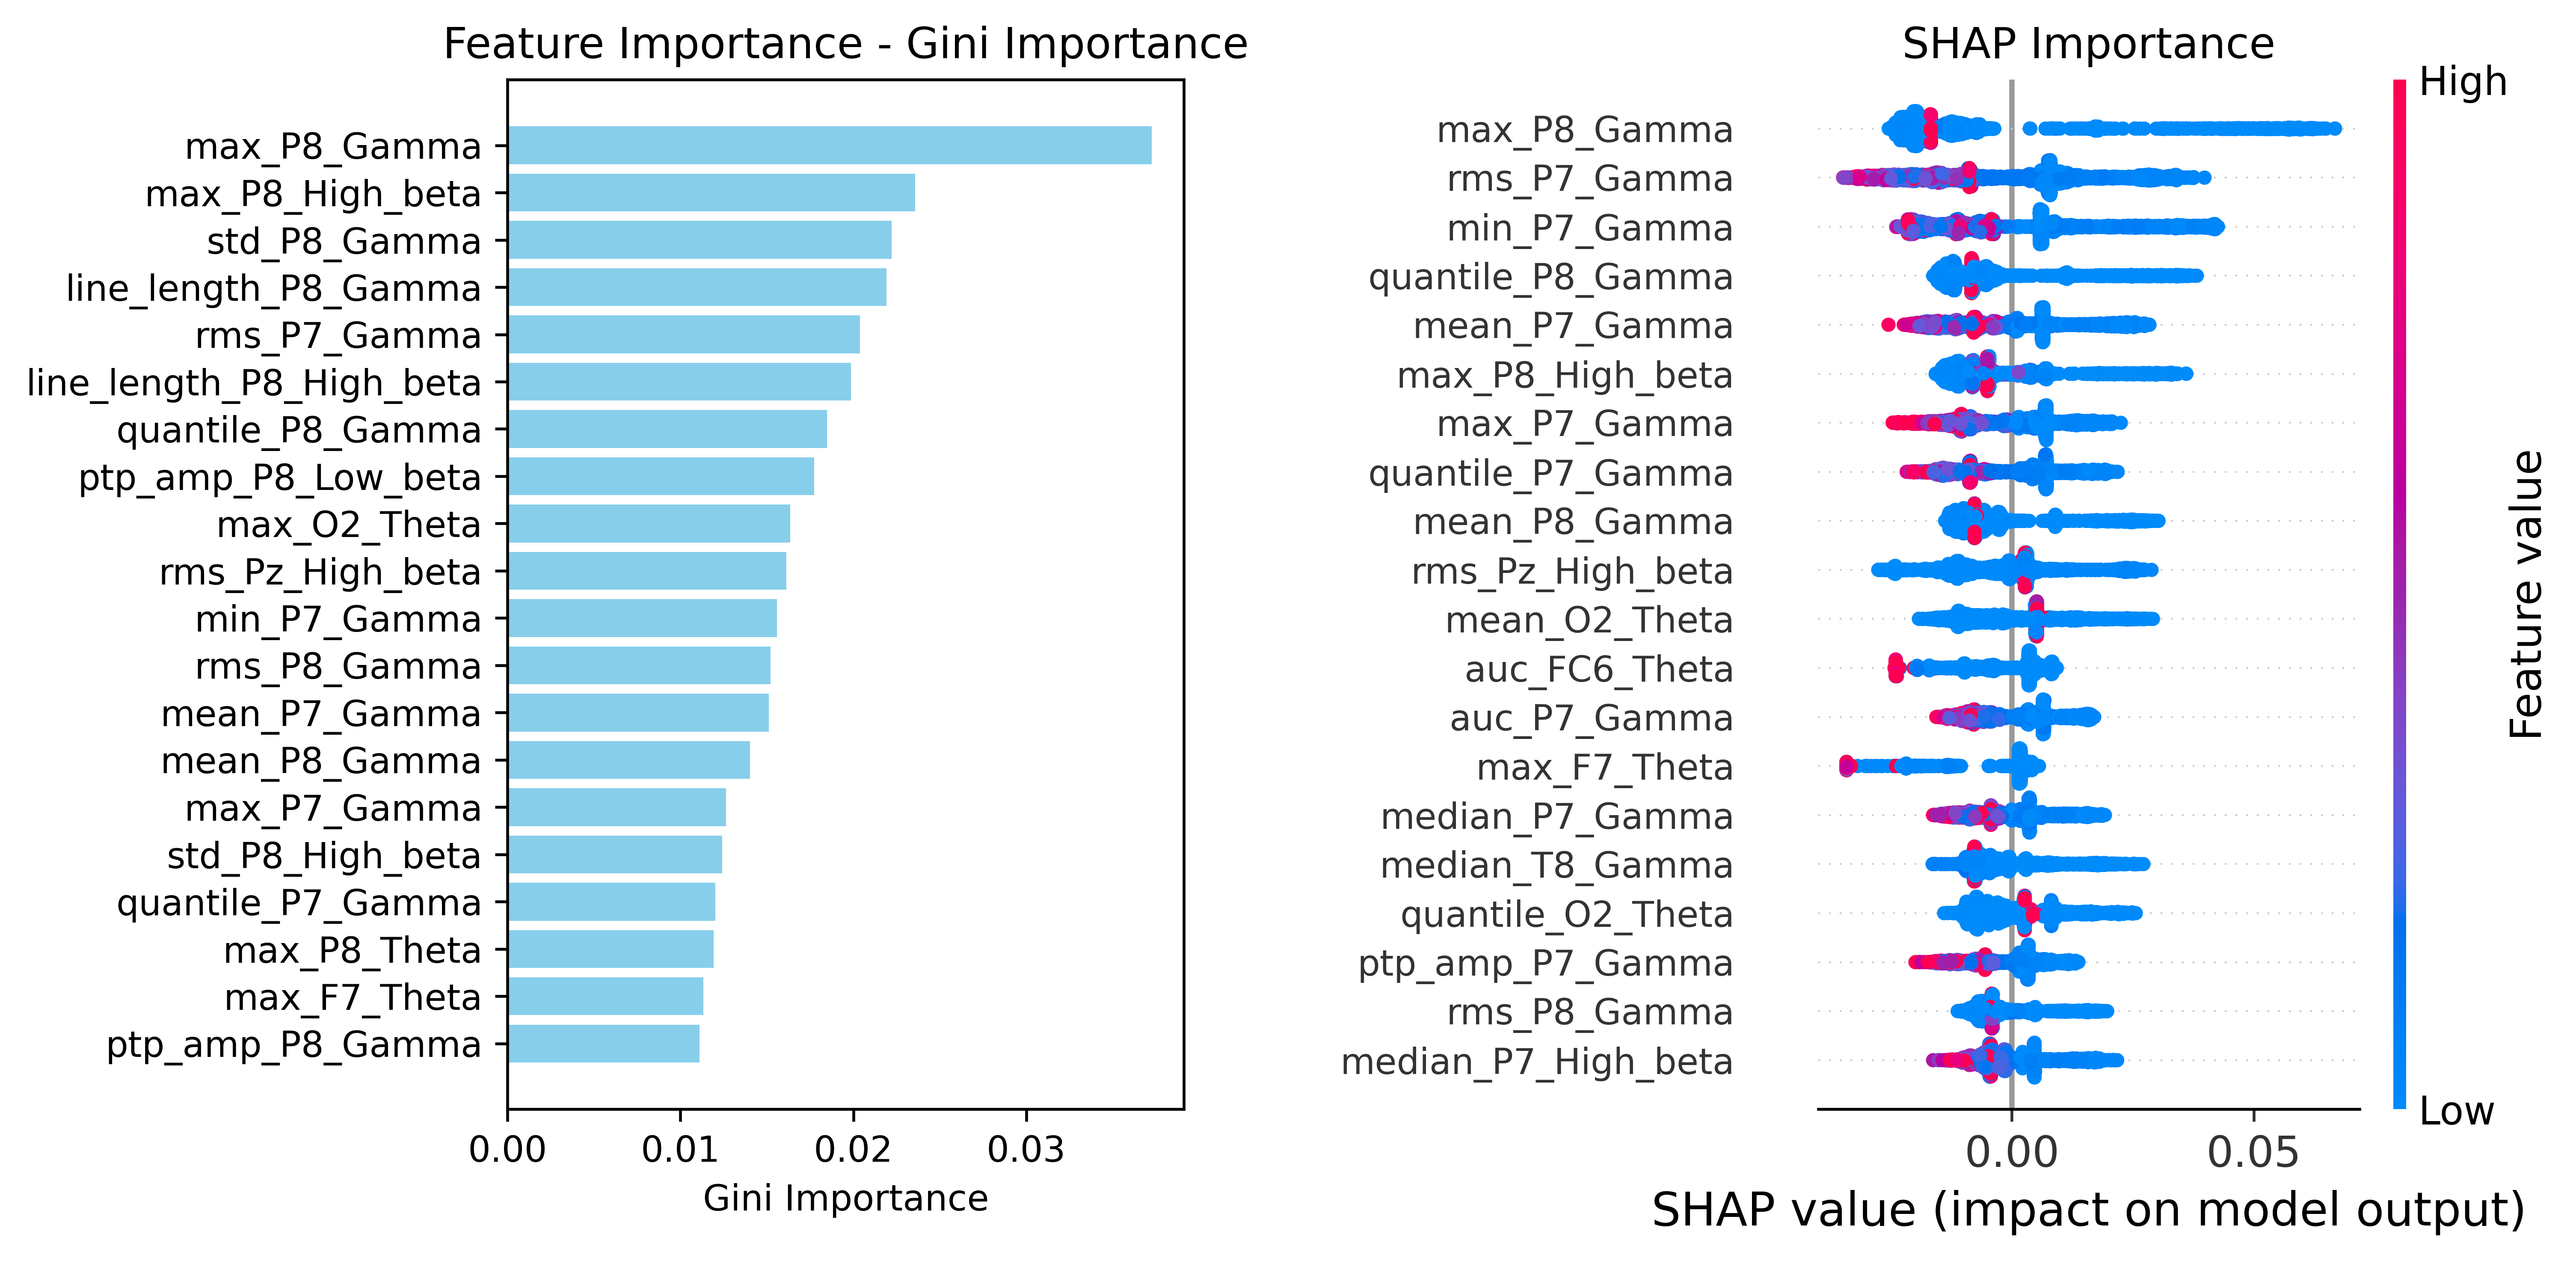

In [127]:
upsampling = ADASYN(sampling_strategy=0.65,random_state=random_state)
best_model =  RandomForestClassifier(random_state = random_state,
                                                n_jobs = -1,
                                                max_features = 'sqrt',
                                                max_depth = 5,
                                                criterion = 'gini',
                                                ccp_alpha = 0.001)

X_res, y_res = upsampling.fit_resample(X_train_val_sel,labels)
best_model.fit(X_res, y_res)
y_pred = best_model.predict_proba(X_test_sel)[:, 1]
evaluate_model(y_test, y_pred,'Random Forest')

get_feature_importance(best_model,X_res,X_test_sel,np.array(feature_names_ext)[select_k_best.get_support(indices=True)],top_n=20)

# Conclusion

As a result, we found that the best prediction of players' skills is achieved using the Random Forest classifier with parameters (ccp=0.001, criterion=gini, max_depth=5, max_features=sqrt) on mixed features with preliminary application of SelectKBest to select 500 most significant features and subsequent use ADASYN upsampling method to increase the minority/majority class ratio to 0.65.

According to the feature importance analysis above, it is evident that, as mentioned earlier, the most distinctive patterns of brain activity of casual and pro players are in the gamma, beta, and theta frequency bands, as well as in the temporal cortex, the frontal lobe, and the parietal cortex. Such findings are fully consistent with the previously obtained results at the exploratory data analysis stage, as well as existing articles.
In general, it can be concluded that i) increased concentration and focus on the sound environment and sound accompaniment in the game (channels T7, P7, T8, P8, rhythm bands Gamma and Beta) reflects a low level of gaming skill, and vice versa, concentration on processing visual stimuli in the game, and coordinated motor actions in response to them are characteristic of pro players. (channels Pz, O2, rhythm Theta).\
Also note that autonomic indices do not listed as the most significant in any of the feature importance graphs, although using a mixed set of features with their inclusion provides improved performance compared to time-domain features alone. This supports their usefulness.